In [ ]:
from preprocessing import preprocess_flowdata, preprocess_graph
from dataset import WaterFlowDataSet
from model import GNN
import torch
from torch_geometric.nn import GCNConv
import torch.nn as nn

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
import torch
from sklearn.model_selection import train_test_split
from eda import plotGraph

In [2]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [ ]:
df_node_features, df_node_features_strata = preprocess_flowdata(FLOWDATA_PATH)
edge_indices, edge_weights = preprocess_graph(SUBSETGRAPH_PATH)

KeyError: '[6250] not in index'

In [4]:
train_dataset = WaterFlowDataSet(df_node_features[0], df_node_features_strata[0], edge_indices, edge_weights)
val_dataset = WaterFlowDataSet(df_node_features[1], df_node_features_strata[1], edge_indices, edge_weights)
test_dataset = WaterFlowDataSet(df_node_features[2], df_node_features_strata[2], edge_indices, edge_weights)

In [5]:
model = GNN(input_channels = 12, hidden_channels = 12, output_channels = 12)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [6]:
def train(model, optimiser, data):
    model.train()
    optimiser.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.mask], data.y[data.mask].squeeze()) 
    #print(loss, out[data.mask], data.y[data.mask].squeeze())
    #print(out[data.mask])
    #print(data.y[data.mask].squeeze())
    loss.backward()
    optimiser.step()
    return loss.item()

def xtrain(model, optimiser, loader):
    model.train()
    total_loss = 0

    for batch in loader:  # batch is a PyG Batch object
        optimiser.zero_grad()
        out = model(batch.x, batch.edge_index)  # pass batch info if needed
        loss = criterion(out[batch.mask], batch.y[batch.mask].squeeze())
        #print(loss)
        loss.backward()
        optimiser.step()
        total_loss += loss.item() * batch.num_graphs  # weighted by number of graphs

    return total_loss / len(loader.dataset)

def validate (model, data):
    model.eval()
    with torch.no_grad():
        out =model(data.x, data.edge_index) 
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask].squeeze())
    return val_loss.item()

In [14]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [17]:
train_loss = []
val_loss = []

for epoch in range(300):
    epoch_train_loss = xtrain(model, optimiser, train_loader)  # pass loader
    train_loss.append(epoch_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}")

Epoch 1, Train Loss: 0.6905691070216042
Epoch 2, Train Loss: 0.6252309445823941
Epoch 3, Train Loss: 0.7154545805283955
Epoch 4, Train Loss: 0.6845246383122036
Epoch 5, Train Loss: 0.7624139572892871
Epoch 6, Train Loss: 0.768368239913668
Epoch 7, Train Loss: 0.611629279596465
Epoch 8, Train Loss: 0.6886860302516392
Epoch 9, Train Loss: 0.749201489346368
Epoch 10, Train Loss: 0.6978245675563812
Epoch 11, Train Loss: 0.7151978292635509
Epoch 12, Train Loss: 0.7430472671985626
Epoch 13, Train Loss: 0.6687738192932946
Epoch 14, Train Loss: 0.7082071006298065
Epoch 15, Train Loss: 0.6771972328424454
Epoch 16, Train Loss: 0.7471578483070646
Epoch 17, Train Loss: 0.6835341240678515
Epoch 18, Train Loss: 0.7816337708915982
Epoch 19, Train Loss: 0.643004276922771
Epoch 20, Train Loss: 0.6531963731561389
Epoch 21, Train Loss: 0.6640263668128422
Epoch 22, Train Loss: 0.6379330967153821
Epoch 23, Train Loss: 0.7483646082026618
Epoch 24, Train Loss: 0.714838200381824
Epoch 25, Train Loss: 0.677862

In [49]:
a = train_dataset[0]
print(a)

Data(x=[6, 12], edge_index=[2, 15], y=[6, 12], mask=[6, 12], edge_weight=[15])


In [46]:
print("Number of graphs:", len(train_dataset))

# Size of first graph
print("First graph:", train_dataset[0])
print("Number of nodes in first graph:", train_dataset[0].num_nodes)
print("Number of edges in first graph:", train_dataset[0].num_edges)

Number of graphs: 224
First graph: Data(x=[6, 12], edge_index=[2, 15], y=[6, 12], mask=[6, 12], edge_weight=[15])
Number of nodes in first graph: 6
Number of edges in first graph: 15


In [45]:
for batch_idx, batch in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print("Batch type:", type(batch))
    
    # batch.x, batch.y, batch.mask, etc. are accessible
    print("x shape:", batch.x.shape)
    print("y shape:", batch.y.shape)
    print("mask shape:", batch.mask.shape)
    print("edge_index shape:", batch.edge_index.shape)
    
    # Show first 2 nodes/features
    print("First 2 x nodes:", batch.x[:2])
    print("First 2 y nodes:", batch.y[:2])
    
    break  # just inspect the first batch


Batch 1
Batch type: <class 'abc.DataBatch'>
x shape: torch.Size([192, 12])
y shape: torch.Size([192, 12])
mask shape: torch.Size([192, 12])
edge_index shape: torch.Size([2, 480])
First 2 x nodes: tensor([[1.6444, 1.6292, 1.5309, 1.6802, 1.6422, 1.6761, 1.8335, 1.7027, 1.5847,
         1.6358, 1.5892, 1.5404],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])
First 2 y nodes: tensor([[1.6444, 1.6292, 1.5309, 1.6802, 1.6422, 1.6761, 1.8335, 1.7027, 1.5847,
         1.6358, 1.5892, 1.5404],
        [1.3408, 1.4191, 1.3437, 1.4377, 1.4110, 1.2270, 1.1973, 1.4083, 1.0176,
         1.0723, 0.9598, 1.1872]])


In [ ]:


train_loss = []
val_loss = []

for epoch in range(300):
    epoch_losses = []  # store batch losses for this epoch

    for data in train_dataset:
        batch_loss = train(model, optimiser, data)  # train on this batch
        epoch_losses.append(batch_loss)

    # average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss.append(avg_epoch_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_epoch_loss}")


Epoch 1, Train Loss: 0.5575993319611631
Epoch 2, Train Loss: 0.5794556333629381
Epoch 3, Train Loss: 0.6422766142765924
Epoch 4, Train Loss: 0.599760494916284
Epoch 5, Train Loss: 0.5613189645913995
Epoch 6, Train Loss: 0.6088138202488024
Epoch 7, Train Loss: 0.5792042799668187
Epoch 8, Train Loss: 0.6232268969678054
Epoch 9, Train Loss: 0.5668666361140952
Epoch 10, Train Loss: 0.6444374102253018
Epoch 11, Train Loss: 0.6403794104241699
Epoch 12, Train Loss: 0.6062984984621705
Epoch 13, Train Loss: 0.5843643599821787
Epoch 14, Train Loss: 0.6293160244261214
Epoch 15, Train Loss: 0.6850728132870115
Epoch 16, Train Loss: 0.5745969195247328
Epoch 17, Train Loss: 0.6059889163131759
Epoch 18, Train Loss: 0.6729161262379161
Epoch 19, Train Loss: 0.6393011950962578
Epoch 20, Train Loss: 0.6289547957588054
Epoch 21, Train Loss: 0.6157501082707313
Epoch 22, Train Loss: 0.5900843799941607
Epoch 23, Train Loss: 0.4961792171379784
Epoch 24, Train Loss: 0.5932444601858151
Epoch 25, Train Loss: 0.63

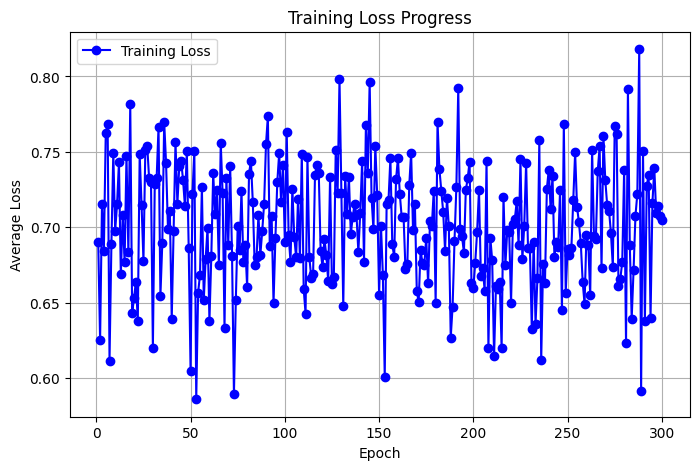

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, 301), train_loss, marker='o', color='blue', label='Training Loss')
plt.title('Training Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
train_loss = []
val_loss = []

for epoch in range(1):
    train_loss.append(train(model, optimiser, train_dataset))
    print(train_loss[-1])
    #val_loss.append(validate(model, test_dataset)) 

AttributeError: 'WaterFlowDataSet' object has no attribute 'x'

In [21]:
print(train_loss)

[28.961515426635742, 18.475557327270508, 17.514236450195312, 18.35321617126465, 16.56226921081543, 18.837583541870117, 18.80560302734375, 22.15268898010254, 16.617921829223633, 18.39676284790039]
